In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# all import statements
import numpy as np
import pandas as pd
import pydicom as pyd
import os
import matplotlib.pyplot as plt
import mudicom

from os.path import dirname, join
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir
from PIL import Image


In [3]:
PATH = 'data/stage_2_train_images/'

In [4]:
lstFilesDCM = []  
for dirName, subdirList, fileList in os.walk(PATH):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [5]:
dcm_500 = []
for img in range(500):
    dcm_500.append(lstFilesDCM[img])

In [6]:
len(dcm_500)

500

In [7]:
dcm_np = []
pat_ids = []
for dcm in dcm_500:
    pat_ids.append(dcm.split('/')[2].split('.')[0])
    img = mudicom.load(dcm)
    img = img.image
    img = img.numpy
    dcm_np.append(img)


In [9]:
import pickle

In [10]:
with open("DCM_NP", "wb") as fp:
    pickle.dump(dcm_np, fp)

In [8]:
def show(img, title=None):
    plt.imshow(img, cmap=plt.cm.bone)
    if title is not None: plt.title = title

def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap=plt.cm.bone)

In [10]:
labels_data = pd.read_csv('data/stage_2_train_labels.csv'); labels_data.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [11]:
labels_patID = labels_data.patientId.values.tolist()

labels_target = labels_data.Target.values.tolist()

labels_x = labels_data.x.values.tolist()

labels_y = labels_data.y.values.tolist()

labels_width = labels_data.width.tolist()

labels_height = labels_data.height.tolist()

In [12]:
dcm_np_target = []
dcm_np_x = []
dcm_np_y = []
dcm_np_width = []
dcm_np_height = []
for data in pat_ids:
    if data in labels_patID:
        idx = labels_patID.index(data)
        dcm_np_target.append(labels_target[idx])
        dcm_np_x.append(labels_x[idx])
        dcm_np_y.append(labels_y[idx])
        dcm_np_width.append(labels_width[idx])
        dcm_np_height.append(labels_height[idx])

In [14]:
len(dcm_np_target), len(dcm_np_x), len(dcm_np_y), len(dcm_np_width), len(dcm_np_height)

(500, 500, 500, 500, 500)

In [15]:
from scipy.misc import imresize
from scipy.signal import convolve2d
import scipy
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

from numpy import newaxis

In [21]:
def conv2d(img, kernel, name = None):
    img = img[newaxis, :, :]
    for x in range(len(img)):
        conv = convolve2d(img[x,:,:], kernel, mode='same')
#         plt.axis('off')
#         plt.imshow(conv, cmap='gray')
#         if name is not None:
#             plt.savefig(str(name)+'.png', bbox_inches='tight')
    return conv

In [17]:
gauss5_k = (1/256)*np.array([
    [1, 4, 6, 4, 1],
    [4, 16, 24, 16, 4],
    [6, 24, 36, 24, 6],
    [4, 16, 24, 16, 4],
    [1, 4, 6, 4, 1]
])

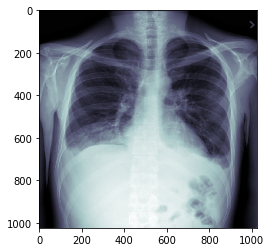

In [23]:
xx = conv2d(dcm_np[100], gauss5_k); show(xx)

In [24]:
for dcm in dcm_np:
    dcm = conv2d(dcm, gauss5_k)

In [28]:
import cv2
from skimage import img_as_float
from skimage import exposure

In [29]:
img_eq = exposure.equalize_hist(dcm_np[100])

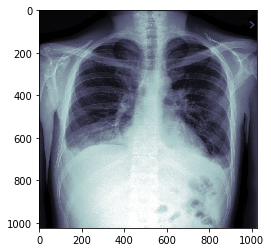

In [30]:
show(img_eq)

In [33]:
image = dcm_np[100].astype('int64')

In [36]:
img_adapteq = exposure.equalize_adapthist(image, clip_limit=0.01)

/usr/local/lib/python3.7/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint16.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.7/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint16 without scaling because max value 248 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


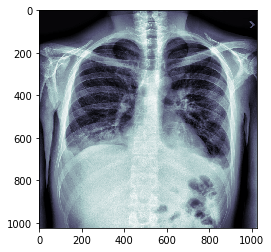

In [37]:
show(img_adapteq)

In [42]:
dcm_adaptiveE = []
for dcm in dcm_np:
    i_f = dcm
    i_int = dcm.astype('int64')
    dcm_adaptiveE.append(exposure.equalize_adapthist(i_int, clip_limit=0.03))
    

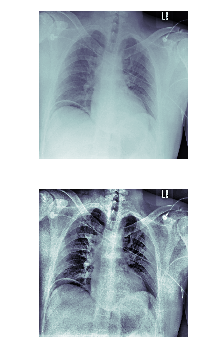

In [44]:
plots([dcm_np[90], dcm_adaptiveE[90]])

In [45]:
dcm_eq = []
for dcm in dcm_np:
    dcm_eq.append(exposure.equalize_hist(dcm))

In [46]:
type(dcm_eq)

list

In [47]:
import pickle

In [49]:
# with open("DCM-EQ", "wb") as fp:
#     pickle.dump(dcm_eq, fp)

In [50]:
# with open("DCM-ADAHIST", "wb") as fp:
#     pickle.dump(dcm_adaptiveE, fp)

In [51]:
# with open("DCM", "wb") as fp:
#     pickle.dump(dcm_np, fp)

In [52]:
# with open("PAT_IDS", "wb") as fp:
#     pickle.dump(pat_ids, fp)

In [53]:
# with open("dcm_target", "wb") as fp:
#     pickle.dump(dcm_np_target, fp)

In [54]:
# with open("dcm_x", "wb") as fp:
#     pickle.dump(dcm_np_x, fp)

In [55]:
# with open("dcm_y", "wb") as fp:
#     pickle.dump(dcm_np_y, fp)

In [56]:
# with open("dcm_width", "wb") as fp:
#     pickle.dump(dcm_np_width, fp)

In [57]:
# with open("dcm_height", "wb") as fp:
#     pickle.dump(dcm_np_height, fp)